In [1]:
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter

class StatsQuantizer(nn.Module):
    def __init__(self, num_bits, clip_learnable):
        super(StatsQuantizer, self).__init__()
        self.num_bits = num_bits
        init_act_clip_val = 2.0

        self.clip_val = nn.Parameter(torch.Tensor([init_act_clip_val]), requires_grad=False)

        self.s = None

    
    def forward(self, weight):

        real_weights = weight

        if len(weight.shape) == 2:
            scaling_factor = 2 * torch.mean(abs(real_weights),dim=1,keepdim=True) # dim, 1
        elif len(weight.shape) == 3:
            scaling_factor = 2 * torch.mean(torch.mean(abs(real_weights),dim=-1,keepdim=True),dim=0,keepdim=True) # 1, dim, 1

        scaling_factor = scaling_factor.detach()
        self.s = scaling_factor.squeeze().cpu()
        scaled_weights = real_weights/scaling_factor
        cliped_weights = torch.clamp(scaled_weights, min=(-self.clip_val/2), max=(self.clip_val/2)-1e-6)
        n = float(2 ** (self.num_bits - 1))
        quan_weights_no_grad = scaling_factor * ((torch.round((cliped_weights) * n - 0.5 ) + 0.5) / n)
        quan_weights = quan_weights_no_grad.detach() - real_weights.detach() + real_weights

        return quan_weights
    

class AdaRoundQuantizer(nn.Module):
    """
    Adaptive Rounding Quantizer, used to optimize the rounding policy
    by reconstructing the intermediate output.
    Based on
     Up or Down? Adaptive Rounding for Post-Training Quantization: https://arxiv.org/abs/2004.10568

    :param uaq: UniformAffineQuantizer, used to initialize quantization parameters in this quantizer
    :param round_mode: controls the forward pass in this quantizer
    :param weight_tensor: initialize alpha
    """

    def __init__(self, wbits=2,sym= False, weight_tensor: torch.Tensor=None, round_mode='learned_hard_sigmoid'):
        super(AdaRoundQuantizer, self).__init__()
        # copying all attributes from UniformAffineQuantizer
        self.sym = sym
        self.delta = nn.Parameter(torch.Tensor([1]), requires_grad=True)
        self.zero_point = nn.Parameter(torch.Tensor([0]), requires_grad=True)
        self.n_levels = 2 ** wbits

        self.round_mode = round_mode
        self.alpha = None
        self.soft_targets = True

        # params for sigmoid function
        self.gamma, self.zeta = -0.1, 1.1
        self.beta = 2/3
        self.init_alpha(x=weight_tensor.clone())
        self.scale = self.delta

    def forward(self, x,soft_targets=True):
        if self.round_mode == 'nearest':
            x_int = torch.round(x / self.delta)
        # elif self.round_mode == 'nearest_ste':
        #     x_int = round_ste(x / self.delta)
        elif self.round_mode == 'stochastic':
            x_floor = torch.floor(x / self.delta)
            rest = (x / self.delta) - x_floor  # rest of rounding
            x_int = x_floor + torch.bernoulli(rest)
            print('Draw stochastic sample')
        elif self.round_mode == 'learned_hard_sigmoid':
            x_floor = torch.floor(x / self.delta)
            if soft_targets:
                x_int = x_floor + self.get_soft_targets()
            else:
                x_int = x_floor + (self.alpha >= 0).float()
        else:
            raise ValueError('Wrong rounding mode')

        x_quant = torch.clamp(x_int + self.zero_point, 0, self.n_levels - 1)
        x_float_q = (x_quant - self.zero_point) * self.delta

        return x_float_q

    def get_soft_targets(self):
        return torch.clamp(torch.sigmoid(self.alpha) * (self.zeta - self.gamma) + self.gamma, 0, 1)

    def init_alpha(self, x: torch.Tensor):
        x_floor = torch.floor(x / self.delta)
        if self.round_mode == 'learned_hard_sigmoid':
            print('Init alpha to be FP32')
            rest = (x / self.delta) - x_floor  # rest of rounding [0, 1)
            alpha = -torch.log((self.zeta - self.gamma) / (rest - self.gamma) - 1)  # => sigmoid(alpha) = rest
            self.alpha = nn.Parameter(alpha)
        else:
            # raise NotImplementedError
            pass

class QLinear(nn.Linear):

    def __init__(self, *kargs, m: torch.nn.Linear, weight_bits=2, input_bits=8, aq_learnable=True, wq_learnable = True,
                 symmetric=True, weight_channelwise=True, input_channelwise=True, weight_quant_method="statsq", input_quant_method="lsq",
                 pretrained_initialized = False,
                 **kwargs):
        super(QLinear, self).__init__(m.in_features, m.out_features,bias=True)
        self.weight_bits = weight_bits
        self.input_bits = input_bits
        self.aq_learnable = aq_learnable
        self.wq_learnable = wq_learnable
        self.symmetric = symmetric
        self.weight_channelwise = weight_channelwise # not gonna used atm
        self.input_channelwise = input_channelwise
        self.weight_quant_method = weight_quant_method
        self.input_quant_method = input_quant_method
        self.pretrained_initialized = pretrained_initialized
        self.weight = torch.nn.Parameter(m.weight.detach())
        if m.bias is not None:
            self.bias = torch.nn.Parameter(m.bias.detach())
        # self.statsq_fn = StatsQuantizer(num_bits=self.weight_bits, clip_learnable=wq_learnable).to(m.weight.device)
        self.fake_quant_fn = AdaRoundQuantizer(weight_tensor=m.weight).to(m.weight.device)

    def get_inferred_params(self):
        int_weight = self.fake_quant_fn(self.weight,True)
        scale = self.fake_quant_fn.scale
        return int_weight, scale.unsqueeze(0), torch.tensor([0.0])
    def set_quant_state(self,state):
        pass
    def forward(self, input):

        # quantize weight
        if self.weight_quant_method == 'statsq':
            weight = self.fake_quant_fn(self.weight)
        else:
            raise ValueError("Unknown quant_method")    
        # quantize input
        out = nn.functional.linear(input, weight)
        if not self.bias is None:
            out += self.bias.view(1, -1).expand_as(out)

        return out

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from EfficientQAT.quantize.int_linear_fake import QuantLinear
# Parameters
input_dim = 8
output_dim = 1
num_samples = 320
device = torch.device("cuda:5")

torch.manual_seed(2)

# Generating synthetic data
X = torch.randn(num_samples, input_dim)*7  # Input features
true_weights = torch.randn(input_dim, output_dim)  # True weights
# true_weights = torch.tensor([[4] ,[1.8],[0.03]])

# true_bias = torch.randn(output_dim)  # True bias
y = X @ true_weights + torch.randn_like(X @ true_weights) * 0.0005  # Adding noise


# Creating dataset and dataloader
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Defining a linear regression model
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.in_features = input_dim
        self.out_features = output_dim
        self.group_size = input_dim
        self.linear = QuantLinear(self.linear, wbits=2, group_size=self.group_size,args={
            # "gradual_quant":True,
            "iterative_freezing":True,
            "freeze_threshold":0.0
        })
        # self.linear = QLinear(m=self.linear)
        self.linear.bias = None
        self.linear.set_quant_state(True)
        # print(self.linear.weight_quantizer.scale)
        # print(self.linear.weight.amin([-1], keepdim=True))
        self.bits =2
        self.logs = {
            "steps": [],
            "quant_weight": [],
            "quant_zero_point": [],
            "quant_scale": [],
            "quant_weight2" : [],
            "quant_zero_point2" : [],
            "quant_scale2" : [],
            "quant_weight3" : [],
            "quant_zero_point3" : [],
            "quant_scale3" : [],
            "weight_position":(0,0),
            "weight_position2":(0,1),            
            "weight_position3":(0,2),
        }
        self.step = 0

    def forward(self, x):
        return self.linear(x)
    
    def examine_weights(self):
        prod = self.logs["weight_position"]
        prod = prod[0]*self.in_features + prod[1]
        g_idx = (prod//self.group_size, prod%self.group_size)
        int_weight,scale,zero_point = self.linear.get_inferred_params()

        self.logs["quant_weight"].append(int_weight.reshape(-1,self.group_size)[g_idx].clone().detach().cpu().item())
        self.logs["quant_zero_point"].append(zero_point[g_idx[0]].clone().detach().cpu().item())
        self.logs["quant_scale"].append(scale[g_idx[0]].clone().detach().cpu().item())
        
        prod = self.logs["weight_position2"]
        prod = prod[0]*self.in_features + prod[1]
        g_idx = (prod//self.group_size, prod%self.group_size)
        self.logs["quant_weight2"].append(int_weight.reshape(-1,self.group_size)[g_idx].clone().detach().cpu().item())
        self.logs["quant_zero_point2"].append(zero_point[g_idx[0]].clone().detach().cpu().item())
        self.logs["quant_scale2"].append(scale[g_idx[0]].clone().detach().cpu().item())

        prod = self.logs["weight_position3"]
        prod = prod[0]*self.in_features + prod[1]
        g_idx = (prod//self.group_size, prod%self.group_size)
        self.logs["quant_weight3"].append(int_weight.reshape(-1,self.group_size)[g_idx].clone().detach().cpu().item())
        self.logs["quant_zero_point3"].append(zero_point[g_idx[0]].clone().detach().cpu().item())
        self.logs["quant_scale3"].append(scale[g_idx[0]].clone().detach().cpu().item())
        
        self.logs["steps"].append(self.step)
        self.step += 1

# Initialize the model
model = LinearRegressionModel(input_dim, output_dim)
# Move the model to device
model.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.1)

loss_list = []

# Train the model
for epoch in range(100):
    running_loss = 0.0
    # if epoch %4:
    for i, data in enumerate(dataloader, 0):
        # for param_group in optimizer.param_groups:
        #     param_group['lr'] = param_group['lr'] / (model.step+1)
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # with torch.no_grad():
        #     grad = model.linear.weight.grad
        #     grad *= model.linear.weight.abs() /model.linear.weight.abs().min()
            # topk_values, topk_indices = torch.topk(grad.flatten(), 4)
            # model.linear.weight.grad = torch.full_like(grad, 1e-12).flatten().scatter_(0, topk_indices, topk_values).view_as(grad)


        optimizer.step()
        with torch.no_grad():
            model.examine_weights()
            print(f"weight1 grad {model.linear.weight.grad} scale grad {model.linear.weight_quantizer.scale.grad} zero_point grad {model.linear.weight_quantizer.zero_point.grad}")
        running_loss += loss.item()
        loss_list.append(loss.item())
    print(f"Epoch {epoch+1} loss: {running_loss/len(dataloader)}")

# Test the model
with torch.no_grad():
    inputs, labels = next(iter(dataloader))
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    # print(f"Test loss: {criterion(outputs, labels)}")

weight1 grad tensor([[ -37.7610,   47.3295, -156.5620,   40.0099,  -24.3504,  -56.4793,
          145.3636,  -81.2330]], device='cuda:5') scale grad tensor([[5.6381]], device='cuda:5') zero_point grad tensor([[0.]], device='cuda:5')
weight1 grad tensor([[  0.0000, -88.2991, -96.2555,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000]], device='cuda:5') scale grad tensor([[-361.3337]], device='cuda:5') zero_point grad tensor([[1.8533]], device='cuda:5')
weight1 grad tensor([[ -79.6681,   65.9012, -175.6507,    0.0000,    0.0000,  -12.2264,
            0.0000, -174.3389]], device='cuda:5') scale grad tensor([[-61.2692]], device='cuda:5') zero_point grad tensor([[-20.2663]], device='cuda:5')
weight1 grad tensor([[-40.2802, -34.8294, -63.1527,   0.0000,   0.0000, -31.4280,   0.0000,
         -96.7003]], device='cuda:5') scale grad tensor([[-91.0165]], device='cuda:5') zero_point grad tensor([[-35.8080]], device='cuda:5')
weight1 grad tensor([[   0.0000, -118.5326, -131.3997,   18.1

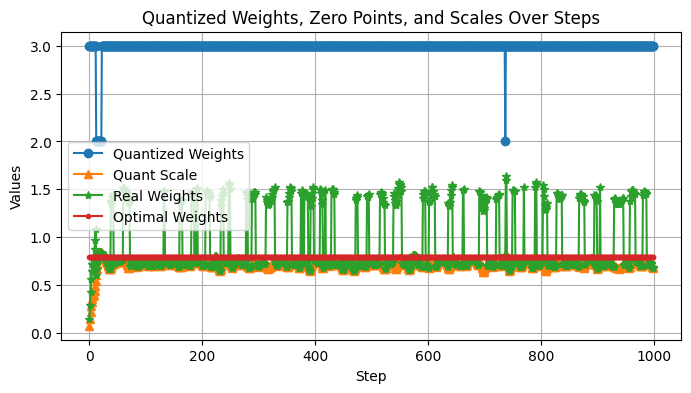

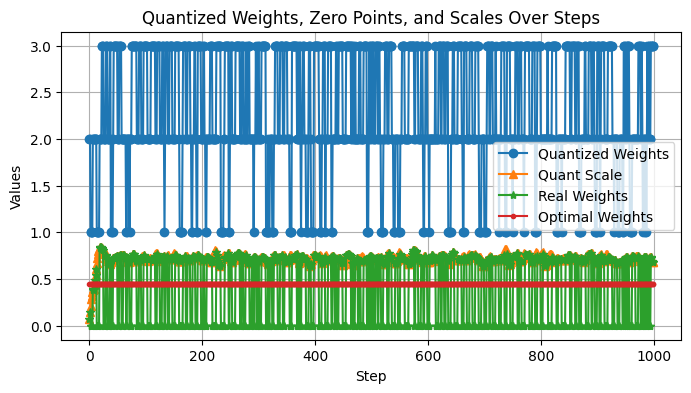

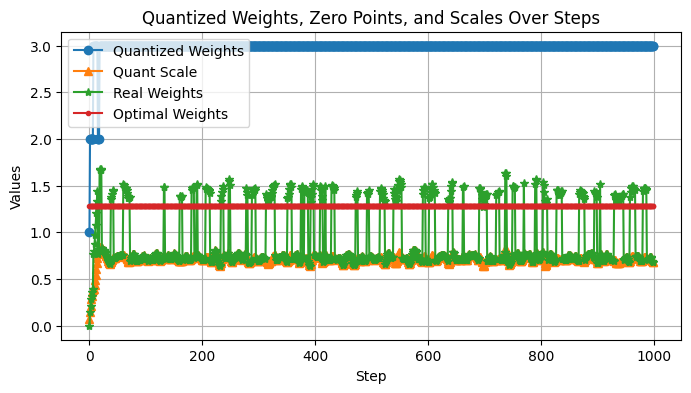

In [3]:
import matplotlib.pyplot as plt
import numpy as np
steps = model.logs["steps"]  # Example step range
quant_weights = model.logs["quant_weight"]  # Example quantized weights
quant_zero_points = model.logs["quant_zero_point"]  # Example zero points
quant_scales = model.logs["quant_scale"]  # Example scales

step = np.array(steps)
quant_weight = np.array(quant_weights)
quant_zero_point = np.array(quant_zero_points)
quant_scale = np.array(quant_scales)
real_weight = (quant_weight-quant_zero_point)*quant_scale
optimal = true_weights[0].item()
optimal = np.array([optimal]*len(step))

# Plotting
plt.figure(figsize=(8,4))
plt.plot(steps, quant_weights, label="Quantized Weights", marker='o')
# plt.plot(steps, quant_zero_points, label="Quant Zero Point", marker='s')
plt.plot(steps, quant_scales, label="Quant Scale", marker='^')
# plt.plot(steps, loss_list, label="Training Loss", marker='x')
plt.plot(steps, real_weight, label="Real Weights", marker='*')
plt.plot(steps, optimal, label="Optimal Weights", marker='.')
plt.xlabel("Step")
plt.ylabel("Values")
plt.title("Quantized Weights, Zero Points, and Scales Over Steps")
plt.legend()
plt.grid(True)
plt.show()

quant_weights = model.logs["quant_weight2"]  # Example quantized weights
quant_zero_points = model.logs["quant_zero_point2"]  # Example zero points
quant_scales = model.logs["quant_scale2"]  # Example scales

step = np.array(steps)
quant_weight = np.array(quant_weights)
quant_zero_point = np.array(quant_zero_points)
quant_scale = np.array(quant_scales)
real_weight = (quant_weight-quant_zero_point)*quant_scale
optimal = true_weights[1,0].item()
optimal = np.array([optimal]*len(step))
# Plotting
plt.figure(figsize=(8,4))
plt.plot(steps, quant_weights, label="Quantized Weights", marker='o')
# plt.plot(steps, quant_zero_points, label="Quant Zero Point", marker='s')
plt.plot(steps, quant_scales, label="Quant Scale", marker='^')
# plt.plot(steps, loss_list, label="Training Loss", marker='x')
plt.plot(steps, real_weight, label="Real Weights", marker='*')
plt.plot(steps, optimal, label="Optimal Weights", marker='.')
plt.xlabel("Step")
plt.ylabel("Values")
plt.title("Quantized Weights, Zero Points, and Scales Over Steps")
plt.legend()
plt.grid(True)
plt.show()

quant_weights = model.logs["quant_weight3"]  # Example quantized weights
quant_zero_points = model.logs["quant_zero_point3"]  # Example zero points
quant_scales = model.logs["quant_scale3"]  # Example scales

step = np.array(steps)
quant_weight = np.array(quant_weights)
quant_zero_point = np.array(quant_zero_points)
quant_scale = np.array(quant_scales)
real_weight = (quant_weight-quant_zero_point)*quant_scale
optimal = true_weights[2,0].item()
optimal = np.array([optimal]*len(step))
# Plotting
plt.figure(figsize=(8,4))
plt.plot(steps, quant_weights, label="Quantized Weights", marker='o')
# plt.plot(steps, quant_zero_points, label="Quant Zero Point", marker='s')
plt.plot(steps, quant_scales, label="Quant Scale", marker='^')
# plt.plot(steps, loss_list, label="Training Loss", marker='x')
plt.plot(steps, real_weight, label="Real Weights", marker='*')
plt.plot(steps, optimal, label="Optimal Weights", marker='.')
plt.xlabel("Step")
plt.ylabel("Values")
plt.title("Quantized Weights, Zero Points, and Scales Over Steps")
plt.legend()
plt.grid(True)
plt.show()
